Fruit Classification Using Transfer Learning


Impot Library

In [1]:
# Import Library Essensial
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import os
import zipfile

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path ke file ZIP di Google Drive
zip_path = '/content/drive/MyDrive/Download/extracted_data/fruitclassficication.zip'

# Ekstrak file ZIP ke folder /content/my_data
extract_path = '/content/my_data'

# Ekstrak file ZIP ke folder tujuan
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Pastikan folder berhasil diekstrak
print(os.listdir(extract_path))

['MY_data']


In [4]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 10
EPOCHS = 20

In [5]:
# Direktori dataset
train_dir = '/content/my_data/MY_data/train'
test_dir = '/content/my_data/MY_data/test'
predict_dir = '/content/my_data/MY_data/predict'

In [6]:
# Data generator untuk train, val, dan test
train_datagen = ImageDataGenerator(rescale = 1./255,
                             rotation_range=40,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             validation_split=0.2)

val_datagen = ImageDataGenerator(rescale = 1./255,
                                validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Load data train
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset="training",
    seed=123
)

#load data val
validation_ds = val_datagen.flow_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    target_size=(IMAGE_SIZE),
    class_mode='categorical',
    subset="validation",
    seed=123
)
# Load data test
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

Found 1841 images belonging to 10 classes.
Found 460 images belonging to 10 classes.
Found 1025 images belonging to 10 classes.


In [8]:
# Daftar Kelas Buah (sesuaikan dengan nama folder)
CLASSES = sorted(os.listdir(train_dir))
print("Kelas Terdeteksi:", CLASSES)

Kelas Terdeteksi: ['Apple', 'Banana', 'avocado', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']


In [9]:
# Create an empty list to store the data
data = []

# Iterate through the subdirectories (categories) in train_dir
for category in os.listdir(train_dir):
    category_path = os.path.join(train_dir, category)

    # Iterate through the images in each category subdirectory
    for filename in os.listdir(category_path):
        # Append the filename and category to the data list
        data.append({'filename': filename, 'category': category})

# Create a pandas DataFrame from the collected data
df_train = pd.DataFrame(data)

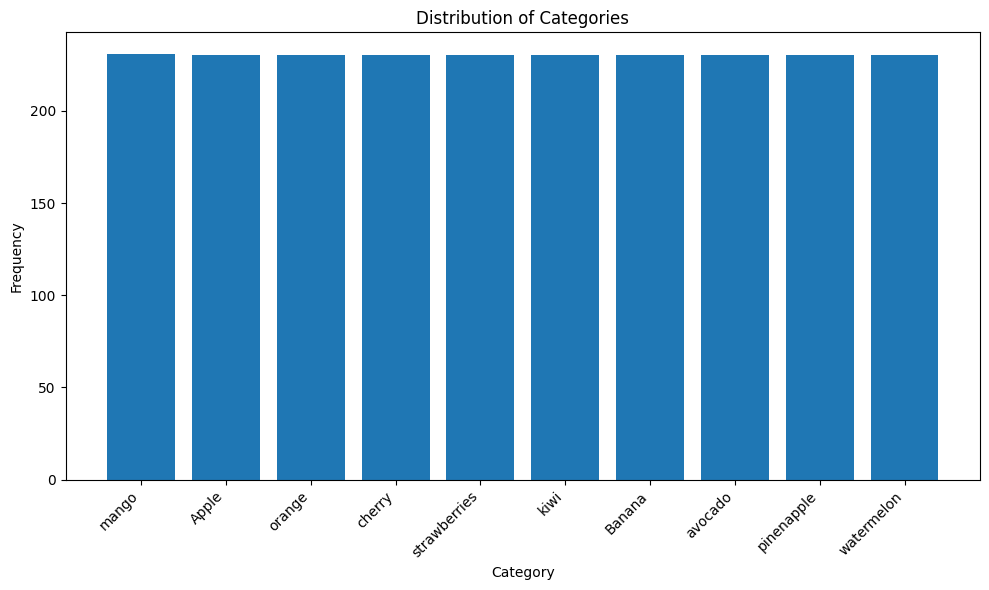

In [10]:
# Count the occurrences of each category
category_counts = df_train['category'].value_counts()


# Create the histogram
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.bar(category_counts.index, category_counts.values)
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Distribution of Categories')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


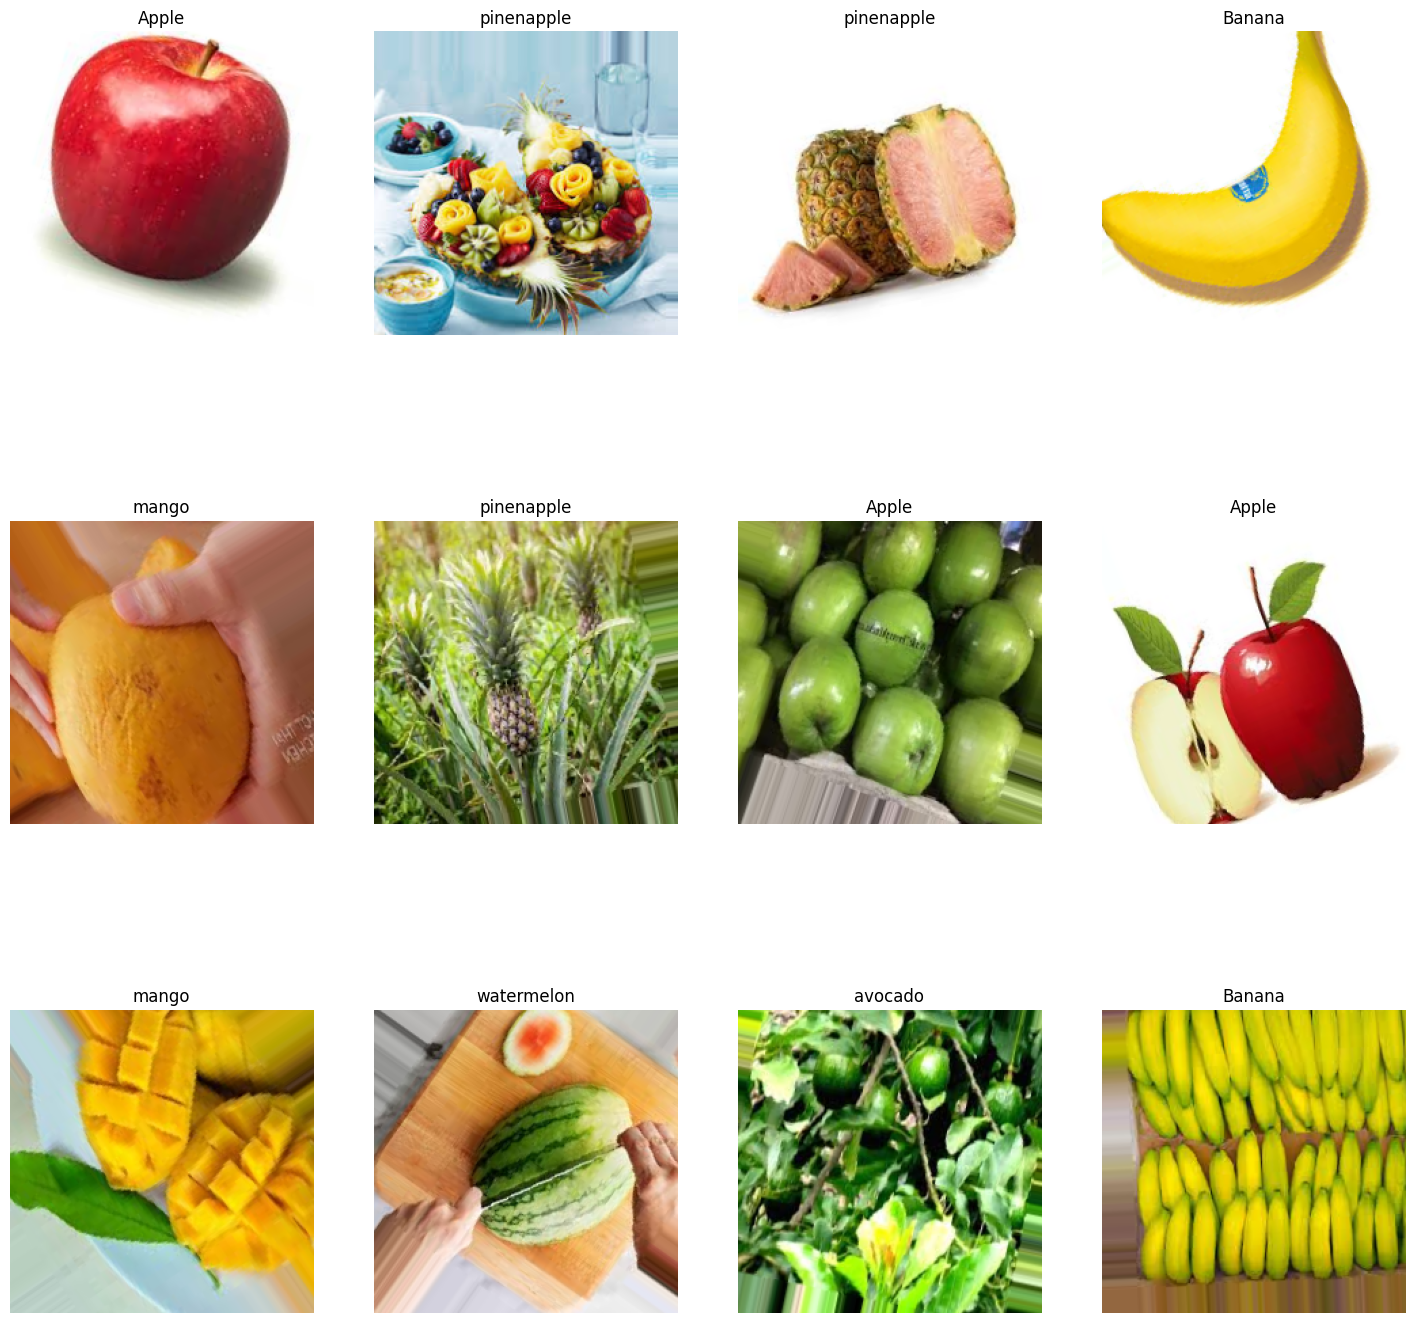

In [11]:
# plot train image
fruit_list = CLASSES
x, y = next(train_generator)

plt.figure(figsize = (18,18))
for i in range(12):
    image = x[i]
    plt.subplot(3, 4, i+1)
    plt.imshow(image)

    # Get the index of the predicted class (highest probability)
    predicted_class_index = np.argmax(y[i])

    plt.title(fruit_list[predicted_class_index]) # Use the predicted class index
    plt.axis('off')

plt.show()

In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Load the pre-trained EfficientNetB4 model without the top classification layer
MobileNetV2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3),
                              pooling='avg')

# Freeze the pre-trained base model layer
MobileNetV2_base.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [13]:
# Build the model
model = Sequential()

# Add the pre-trained Xception base
model.add(MobileNetV2_base)

# Batch Normalization
model.add(BatchNormalization())

# Flattening Layer
model.add(Flatten())

# Add a dense layer with 120 units and ReLU activation function
model.add(Dense(256, activation='relu'))

# Add a dense layer with 120 units and ReLU activation function
model.add(Dense(128, activation='relu'))

# Add a dense layer with 120 units and ReLU activation function
model.add(Dense(64, activation='relu'))

# Add a dense layer with 120 units and ReLU activation function
model.add(Dense(32, activation='relu'))

# Add the output layer with 1 unit and sigmoid activation function for binary classification
model.add(Dense(10, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,634,602 (10.05 MB)

 Trainable params: 374,058 (1.43 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [15]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# Build custom callbacks
reduceLR= ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

callbacks = [reduceLR, early]

class callbacks2(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95 and logs.get('loss') < 0.05):
            print("\nAkurasi telah mencapai >95%!")
            self.model.stop_training = True
on_epoch_end = callbacks2

In [17]:
# Training Model
history= model.fit(train_generator,
    validation_data=validation_ds,
    steps_per_epoch=len(train_generator),
    epochs=50,
    callbacks=[callbacks, callbacks2()]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 56s 684ms/step - accuracy: 0.4931 - loss: 1.5137 - val_accuracy: 0.8609 - val_loss: 0.4477 - learning_rate: 0.0010
Epoch 2/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8609 - val_loss: 0.4477 - learning_rate: 0.0010
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 57s 407ms/step - accuracy: 0.9013 - loss: 0.3019 - val_accuracy: 0.9130 - val_loss: 0.2790 - learning_rate: 0.0010
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9130 - val_loss: 0.2790 - learning_rate: 0.0010
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 26s 398ms/step - accuracy: 0.9313 - loss: 0.2213 - val_accuracy: 0.8957 - val_loss: 0.2850 - learning_rate: 0.0010
Epoch 6/50

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8957 - val_loss: 0.2850 - learning_rate: 0.0010
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 39s 385ms/step - accuracy: 0.9583 - loss: 0.1415 - val_accuracy: 0.9261 - val_loss: 0.2110 - learning_rate: 5.000

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9268 - loss: 0.2238


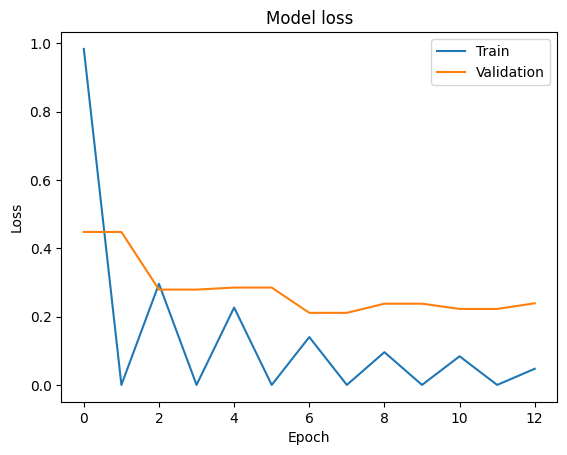

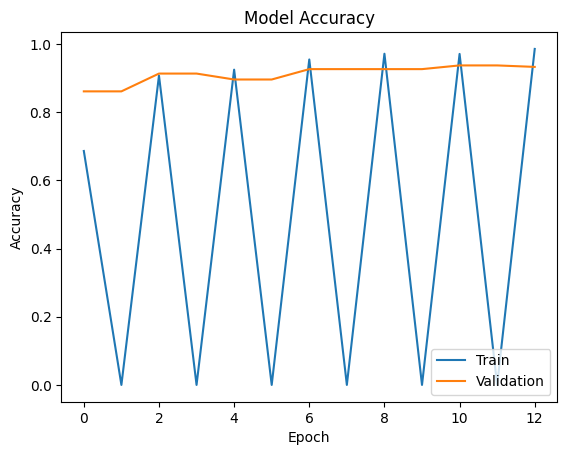

In [18]:
# evaluate the model
loss = model.evaluate(validation_ds)

# Plotting the training and testing loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# plot the accuracy of training and validation

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


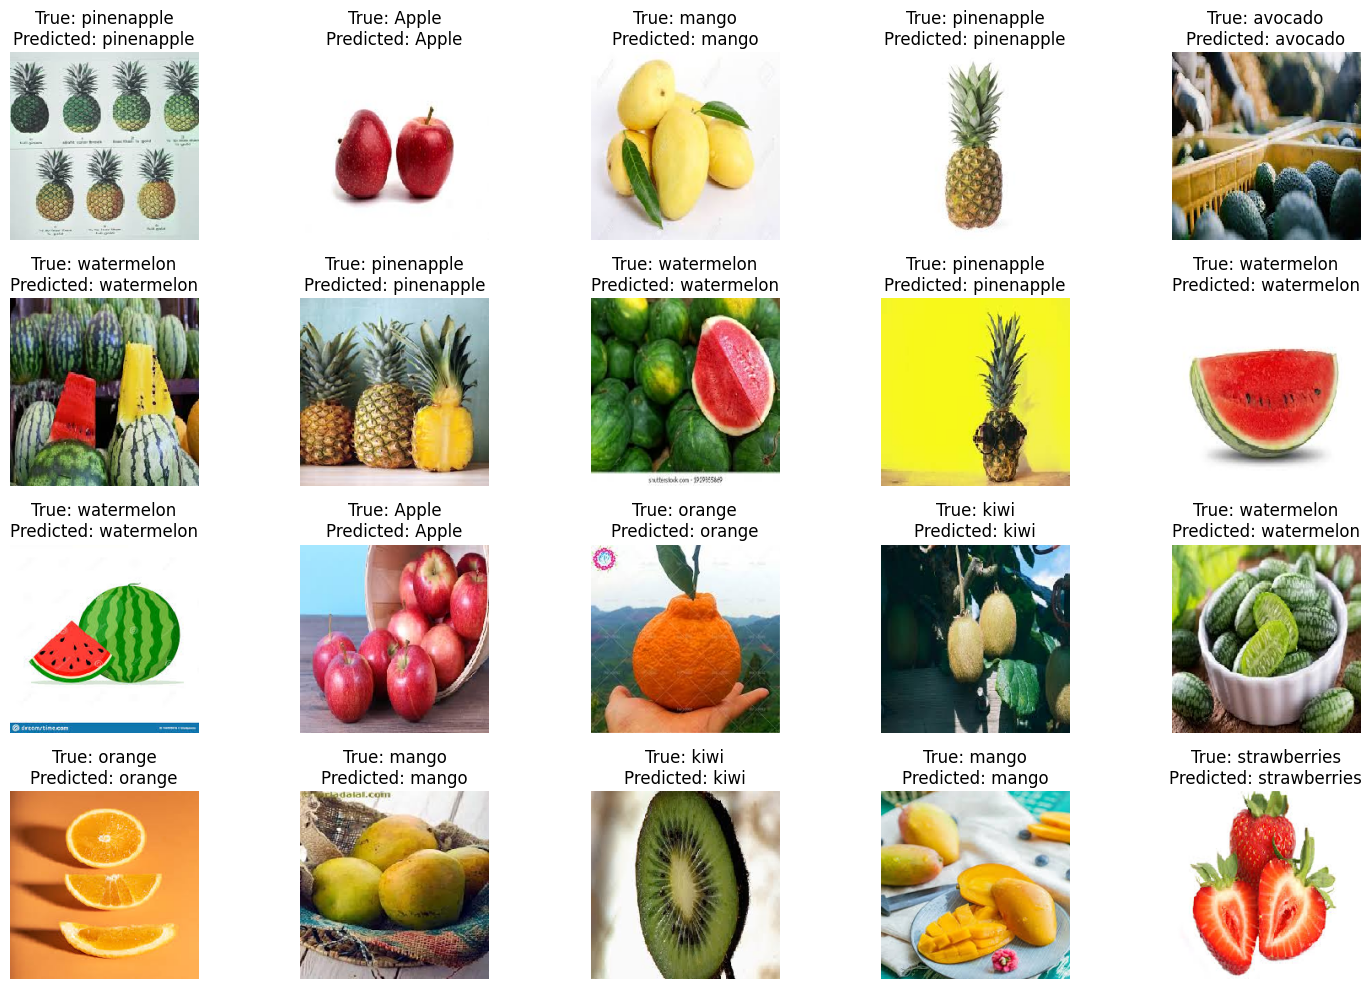

In [20]:
# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Predict on each image and plot results
num_images = 20
num_images_per_row = 5  # Set the number of images per row
num_rows = 4

plt.figure(figsize=(15, 10))
for i in range(num_images):
    image, label = next(validation_ds)
    predictions = model.predict(image)

    # Iterate over each image in the batch
    for j in range(len(image)):
        if i * len(image) + j < num_images:  # Check if the total number of images exceeds the desired count
            predicted_class = class_labels[np.argmax(predictions[j])]
            true_class = class_labels[np.argmax(label[j])]

            plt.subplot(num_rows, num_images_per_row, i * len(image) + j + 1)
            plt.imshow(image[j])
            plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
            plt.axis('off')

plt.tight_layout()
plt.show()

In [21]:
model.save('fruit_classifier_model.h5')